In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("dark")
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
import plotly.figure_factory as ff
from pandas.plotting import lag_plot
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
#from fbprophet import Prophet
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Read and convert dataframe

In [2]:
df=pd.read_csv("crime_clean.csv",parse_dates=True)
df.head()

OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION DISTRICT  \
0           619               Larceny    LARCENY ALL OTHERS      D14   
1          1402             Vandalism             VANDALISM      C11   
2          3410                 Towed   TOWED MOTOR VEHICLE       D4   
3          3114  Investigate Property  INVESTIGATE PROPERTY       D4   
4          3114  Investigate Property  INVESTIGATE PROPERTY       B3   

  REPORTING_AREA OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
0            808   9/2/2018 13:00  2018      9      Sunday    13    Part One   
1            347   8/21/2018 0:00  2018      8     Tuesday     0    Part Two   
2            151   9/3/2018 19:27  2018      9      Monday    19  Part Three   
3            272   9/3/2018 21:16  2018      9      Monday    21  Part Three   
4            421   9/3/2018 21:05  2018      9      Monday    21  Part Three   

         Lat       Long          OFFENSE_TYPE DISTRCIT NAME  
0  42.377875 -71.156442    LARCENY ALL OTHERS      Brighton  
1  42.377875 -71.074495             VANDALISM    Dorchester  
2  42.377875 -71.077230   TOWED MOTOR VEHICLE     South End  
3  42.377875 -71.077230  INVESTIGATE PROPERTY     South End  
4  42.377875 -71.092427  INVESTIGATE PROPERTY      Mattapan

In [3]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE']).dt.floor('d')

In [4]:
df_t=pd.DataFrame(df['OCCURRED_ON_DATE'].value_counts()).reset_index().rename(columns={"index":"Time","OCCURRED_ON_DATE":"Count"})
df_t=df_t.sort_values(by='Time')
df_t.set_index(['Time'],inplace=True)
df_t.head()

Count
Time             
2015-06-15    244
2015-06-16    246
2015-06-17    230
2015-06-18    290
2015-06-19    285

Export the dataset for future use

In [8]:
df_t.to_csv("Daily Incidences.csv")

Set index frequency as a Daily Basis

In [5]:
df_t.index.freq='D'
df_t.index

DatetimeIndex(['2015-06-15', '2015-06-16', '2015-06-17', '2015-06-18',
               '2015-06-19', '2015-06-20', '2015-06-21', '2015-06-22',
               '2015-06-23', '2015-06-24',
               ...
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03'],
              dtype='datetime64[ns]', name='Time', length=1177, freq='D')

Simply Visualize the data to see the general pattern

In [7]:
fig = go.Figure([go.Scatter(x=df_t.index, y=df_t['Count'])],layout=go.Layout(title='Daily Incidences in Boston'))

fig.show()

In [86]:
fig = go.Figure([go.Scatter(x=df_m.index, y=df_m['Count'])],layout=go.Layout(title='Monthly Incidences in Boston'))

fig.show()

Although it happened randomly, there is a periodical trend in the data

**Set window value as 30 days (1 month) to implement SMA and then plot out results**

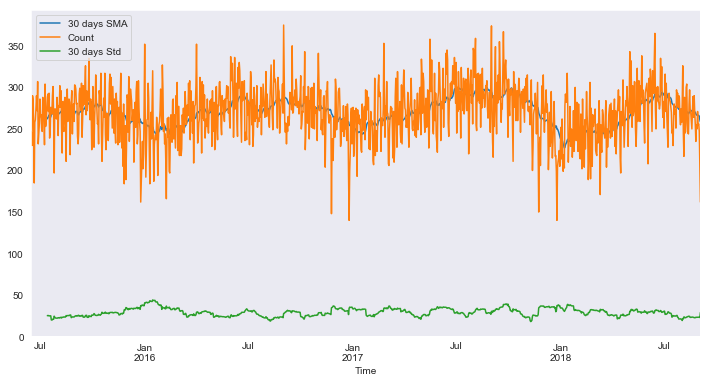

In [9]:
df_t_sma=df_t['Count'].rolling(window=30).mean().rename("30 days SMA")
df_t_std=df_t['Count'].rolling(window=30).std().rename("30 days Std")

df_t_sma.plot(legend=True,figsize=(12,6))
df_t['Count'].plot(legend=True)
df_t_std.plot(legend=True);

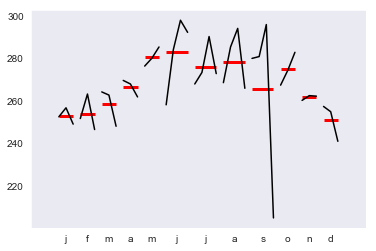

In [87]:
dfm=df_t['Count'].resample(rule='M').mean()
month_plot(dfm);

In [88]:
df_m=pd.DataFrame(dfm)
df_m.head()

Count
Time                  
2015-06-30  258.250000
2015-07-31  268.064516
2015-08-31  268.677419
2015-09-30  280.100000
2015-10-31  267.516129

In [22]:
len(df_m)

40

In [89]:
fig = go.Figure([go.Scatter(x=df_m.index, y=df_m['Count'])],layout=go.Layout(title='Monthly Incidences in Boston'))

fig.show()

**There is a up-and-down trend after resampling date frequency to 'M'**

## Use StatsModels to explore monthly data

**Simple Exponential Smoothing & Exponential Smoothing**

In [51]:
ses=df_m['Count'].ewm(span=6).mean().rename('SES-12')

In [62]:
DES_mul=ExponentialSmoothing(df_m['Count'],trend='mul').fit()
DES_add=ExponentialSmoothing(df_m['Count'],trend='add').fit()

Plot out the first 2 years

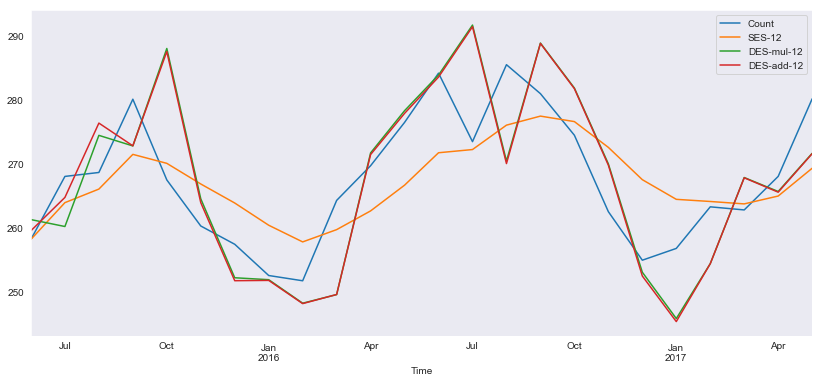

In [64]:
df_m['Count'].iloc[:24].plot(legend=True, figsize=(14,6))
ses.iloc[:24].plot(legend=True)
DES_mul.fittedvalues.rename('DES-mul-12').iloc[:24].plot(legend=True)
DES_add.fittedvalues.rename('DES-add-12').iloc[:24].plot(legend=True)

Plot out the rest years

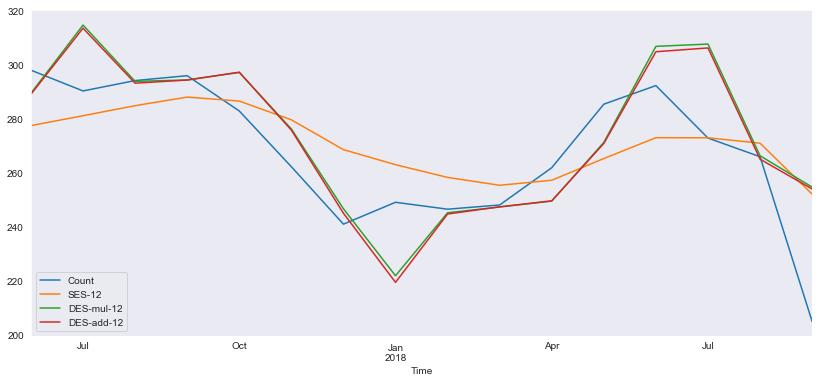

In [65]:
df_m['Count'].iloc[24:].plot(legend=True, figsize=(14,6))
ses.iloc[24:].plot(legend=True)
DES_mul.fittedvalues.rename('DES-mul-12').iloc[24:].plot(legend=True)
DES_add.fittedvalues.rename('DES-add-12').iloc[24:].plot(legend=True)

Both "Multiplicative" and "Addictive" model has almost the same result

Add a seasonality 

In [76]:
TES=ExponentialSmoothing(df_m['Count'],
                                trend='add',
                                seasonal='add',
                                seasonal_periods=12).fit()

#DES_season.fittedvalues.rename('DES-Seasonal-12').plot()

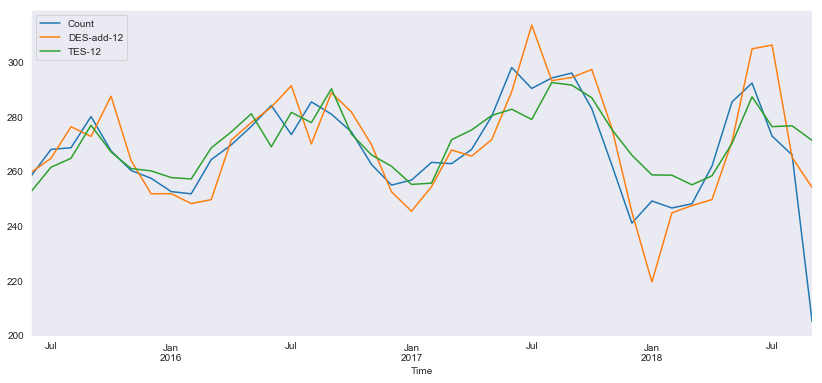

In [78]:
df_m['Count'].plot(legend=True, figsize=(14,6))
#ses.plot(legend=True)
DES_add.fittedvalues.rename('DES-add-12').plot(legend=True)
TES.fittedvalues.rename('TES-12').plot(legend=True)

## Check if data is staionary 

**Visualize the data to check with naked eyes**

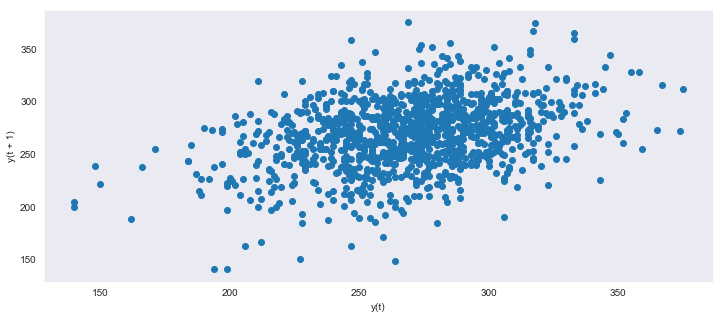

In [11]:
fig,ax=plt.subplots(figsize=(12,5))
lag_plot(df_t['Count'],ax=ax)

**ACF Plot from StatsModels**

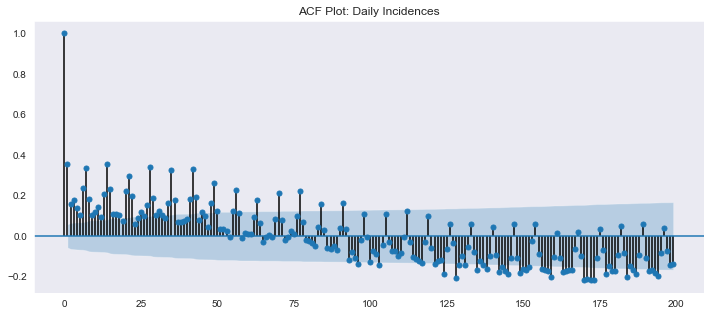

In [12]:
title='ACF Plot: Daily Incidences'
fig,ax=plt.subplots(figsize=(12,5))
plot_acf(df_t, title=title,lags=np.arange(200),ax=ax);

There is a sharp drop off in the plot

**PACF Plot from StatsModels**

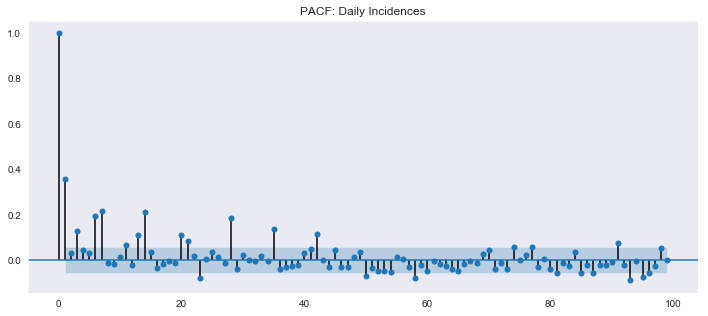

In [13]:
title='PACF: Daily Incidences'
fig,ax=plt.subplots(figsize=(12,5))
plot_pacf(df_t, title=title,lags=np.arange(100),ax=ax);

**Double check the stationality by using the augmented Dickey-Fuller test**

Write a reusable function for stationality test

In [17]:
def adf_test(series):
    
    result=adfuller(series.dropna(),autolag='AIC')
    
    labels=['ADF test statistic','p-value','lags used','observations']
    
    out=pd.Series(result[0:4],index=labels)
    
    for key, val in result[4].items():
        out[f'critical value ({key})']=val
    print(out)
    
    if result[1]<= 0.05:
        print("Data has no unit root and is stationary")
    else:
        print("Data has a unit root and is non-stationary")

In [18]:
adf_test(df_t['Count'])

ADF test statistic        -3.475507
p-value                    0.008639
lags used                 22.000000
observations            1154.000000
critical value (1%)       -3.436029
critical value (5%)       -2.864048
critical value (10%)      -2.568105
dtype: float64
Data has no unit root and is stationary


**Conclusion: Data is stationary**

## Since Data is Stationary, next use ARIMA Model to Forcast to the future

**Apply Grid Search here to determine the suitable orders combination for arima models, since data is stationary, so most likely "I" component will be 0**

Set seasonal parameter as False

In [16]:
arstep=auto_arima(df_t['Count'],
                  start_p=0,
                  start_q=0,
                  max_p=20,max_q=20,
                  seasonal=False,
                  trace=True)
arstep

Fit ARIMA: order=(0, 0, 0); AIC=11567.178, BIC=11577.319, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 0); AIC=11407.452, BIC=11422.664, Fit time=0.030 seconds
Fit ARIMA: order=(0, 0, 1); AIC=11424.671, BIC=11439.883, Fit time=0.027 seconds
Fit ARIMA: order=(2, 0, 0); AIC=11408.064, BIC=11428.347, Fit time=0.036 seconds
Fit ARIMA: order=(1, 0, 1); AIC=11373.985, BIC=11394.268, Fit time=0.203 seconds
Fit ARIMA: order=(2, 0, 2); AIC=11323.029, BIC=11353.454, Fit time=0.417 seconds
Fit ARIMA: order=(1, 0, 2); AIC=11322.756, BIC=11348.110, Fit time=0.361 seconds
Fit ARIMA: order=(1, 0, 3); AIC=11322.795, BIC=11353.219, Fit time=0.467 seconds
Fit ARIMA: order=(2, 0, 3); AIC=11325.725, BIC=11361.220, Fit time=0.559 seconds
Fit ARIMA: order=(0, 0, 2); AIC=11419.115, BIC=11439.397, Fit time=0.042 seconds
Total fit time: 2.159 seconds


ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 0, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [17]:
arstep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1177
Model:                     ARMA(1, 2)   Log Likelihood               -5656.378
Method:                       css-mle   S.D. of innovations             29.563
Date:                Sat, 07 Sep 2019   AIC                          11322.756
Time:                        12:02:02   BIC                          11348.110
Sample:                             0   HQIC                         11332.316
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        268.1867      5.289     50.703      0.000     257.820     278.554
ar.L1.y        0.9882      0.006    178.527      0.000       0.977       0.999
ma.L1.y       -0.7019      0.030    -23.288      0.000      -0.761      -0.643
ma.L2.y       -0.2218      0.029     -7.574      0.000      -0.279      -0.164
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0120           +0.0000j            1.0120            0.0000
MA.1            1.0657           +0.0000j            1.0657            0.0000
MA.2           -4.2305           +0.0000j            4.2305            0.5000
-----------------------------------------------------------------------------
"""

### ARMA

In [18]:
len(df_t)

1177

Split the data into train / test sets

In [9]:
train=df_t.iloc[:942]
test=df_t.iloc[942:]

In [144]:
am_model=ARMA(train['Count'],order=(1,2))
am_result=am_model.fit()

In [58]:
am_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Count   No. Observations:                  942
Model:                     ARMA(1, 2)   Log Likelihood               -4533.097
Method:                       css-mle   S.D. of innovations             29.751
Date:                Sat, 07 Sep 2019   AIC                           9076.194
Time:                        12:35:19   BIC                           9100.434
Sample:                    06-15-2015   HQIC                          9085.433
                         - 01-11-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         267.8313      6.325     42.346      0.000     255.435     280.228
ar.L1.Count     0.9893      0.006    154.844      0.000       0.977       1.002
ma.L1.Count    -0.6894      0.033    -21.019      0.000      -0.754      -0.625
ma.L2.Count    -0.2378      0.032     -7.484      0.000      -0.300      -0.176
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0108           +0.0000j            1.0108            0.0000
MA.1            1.0617           +0.0000j            1.0617            0.0000
MA.2           -3.9603           +0.0000j            3.9603            0.5000
-----------------------------------------------------------------------------
"""

In [59]:
len(train)

942

In [60]:
len(test)

235

In [61]:
start=len(train)
end=len(train)+len(test)

In [145]:
pred=am_result.predict(start,end-1).rename('ARMAR (1,2) Predictions')
pred.head()

2018-01-12    255.610436
2018-01-13    247.091839
2018-01-14    247.312889
2018-01-15    247.531584
2018-01-16    247.747947
Freq: D, Name: ARMAR (1,2) Predictions, dtype: float64

In [150]:
for i in range (len(pred)):
    print(f"prediction={pred[i]}, expected={test['Count'][i]}")

prediction=255.61043590757646, expected=317
prediction=247.09183927817568, expected=277
prediction=247.31288948483063, expected=210
prediction=247.53158363975416, expected=239
prediction=247.74794685479682, expected=239
prediction=247.96200397415592, expected=277
prediction=248.17377957722817, expected=229
prediction=248.38329798143215, expected=250
prediction=248.59058324500052, expected=249
prediction=248.79565916974255, expected=216
prediction=248.99854930377725, expected=234
prediction=249.19927694423723, expected=272
prediction=249.39786513994386, expected=223
prediction=249.59433669405394, expected=239
prediction=249.78871416667798, expected=300
prediction=249.9810198774708, expected=253
prediction=250.17127590819442, expected=236
prediction=250.3595041052535, expected=282
prediction=250.54572608220408, expected=259
prediction=250.7299632222352, expected=223
prediction=250.91223668062432, expected=280
prediction=251.09256738716655, expected=251
prediction=251.27097604857792, expe

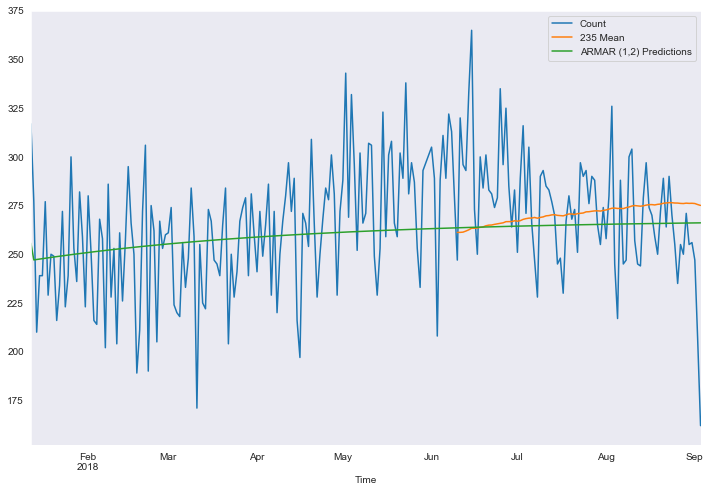

In [146]:
test['Count'].plot(figsize=(12,8),legend=True).autoscale(axis='x',tight=True)
df_t['Daily Mean'] = df_t.iloc[942:]['Count'].rolling(window=150).mean().rename('235 Mean').plot(legend=True)
pred.plot(legend=True);

**Evaluate the model**

In [154]:
error=mean_squared_error(test['Count'],pred)
print(f'ARMA(1,2) MSE Error: {error}')

ARMA(1,2) MSE Error: 962.3177856186719


In [155]:
error=rmse(test['Count'],pred)
print(f'ARMA(1,2) RMSE Error: {error}')

ARMA(1,2) RMSE Error: 31.02124732531998


**Compare the average value of predictions**

In [27]:
print('Mean value of test set: ',test.mean().to_string())

print('Mean value of predictions: ', pred.mean())


Mean value of test set:  Count    265.638298
Mean value of predictions:  260.1990867553384


In [28]:
print("Mean Value Accuracy: {:.0%}".format(260.1990867553384/265.638298))

Mean Value Accuracy: 98%


**Retrain the model then forcast to the future**

In [94]:
arma_model=ARMA(df_t,order=(1,2))
arma_result=arma_model.fit()

set the prediction window to 1 year, which is 365 days

In [109]:
forcast=arma_result.predict(len(df_t),len(df_t)+364).rename('ARMR Forcast for next 1 year')

[Text(0, 0.5, 'Daily Incidence'), Text(0.5, 0, '')]

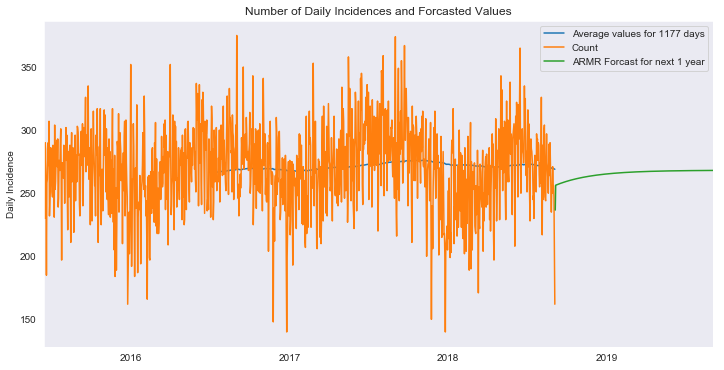

In [118]:
title='Number of Daily Incidences and Forcasted Values'
ylabel='Daily Incidence'
xlabel=''

ax=df_t['Count'].iloc[0:].rolling(window=400).mean().rename('Average values for 1177 days').plot(figsize=(14,8),legend=True)
df_t['Count'].plot(legend=True,figsize=(12,6),title=title)
forcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

## SARIMA (Explore the seasonality)

**ETS Decomposition**

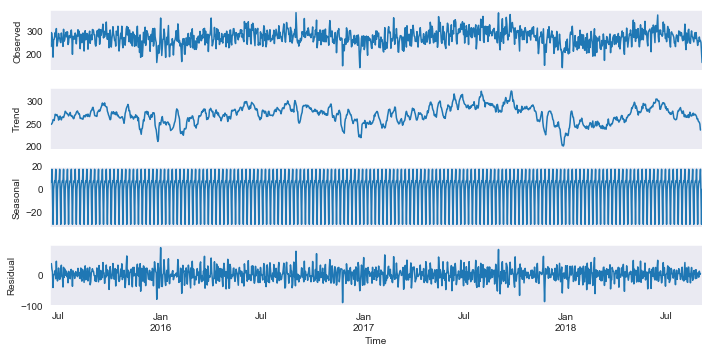

In [27]:
rcParams['figure.figsize']=10,5

result = seasonal_decompose(df_t['Count'],model='additive')
result.plot();

Zoom in the "Seasonal" result to better determing the value of seasonal component

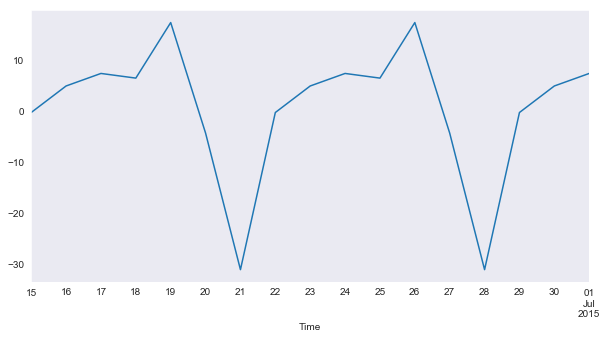

In [28]:
result.seasonal.plot(figsize=(10,5),xlim=['2015-06-15','2015-07-01'])

**Reshape the datasets**

In [220]:
df_day=df[['OCCURRED_ON_DATE','DAY_OF_WEEK']]
df_day.head()

OCCURRED_ON_DATE DAY_OF_WEEK
0       2018-09-02      Sunday
1       2018-08-21     Tuesday
2       2018-09-03      Monday
3       2018-09-03      Monday
4       2018-09-03      Monday

In [221]:
df_day=pd.DataFrame(df.groupby('OCCURRED_ON_DATE')['DAY_OF_WEEK'].value_counts()).rename(columns={"DAY_OF_WEEK":"Count"}).reset_index()
df_day.set_index('OCCURRED_ON_DATE',inplace=True)
df_day.rename(columns={'DAY_OF_WEEK':'Weekday'},inplace=True)
df_day.head()

Weekday  Count
OCCURRED_ON_DATE                  
2015-06-15           Monday    244
2015-06-16          Tuesday    246
2015-06-17        Wednesday    230
2015-06-18         Thursday    290
2015-06-19           Friday    285

In [222]:
df_day.index.freq='D'

In [226]:
dict_={'Saturday':1,
       'Sunday':1,
       'Monday':0,
       'Tuesday':0,
       'Wednesday':0,
       'Thursday':0,
       'Friday':0}

In [227]:
df_day['Weekend']=df_day['Weekday'].map(dict_)

In [233]:
df_day.iloc[4:8]

Weekday  Count  Weekend
OCCURRED_ON_DATE                          
2015-06-19          Friday    285        0
2015-06-20        Saturday    256        1
2015-06-21          Sunday    185        1
2015-06-22          Monday    258        0

In [234]:
df_day['Weekend'].value_counts()

0    841
1    336
Name: Weekend, dtype: int64

In [236]:
df_day.query('Weekend==1').index

DatetimeIndex(['2015-06-20', '2015-06-21', '2015-06-27', '2015-06-28',
               '2015-07-04', '2015-07-05', '2015-07-11', '2015-07-12',
               '2015-07-18', '2015-07-19',
               ...
               '2018-08-04', '2018-08-05', '2018-08-11', '2018-08-12',
               '2018-08-18', '2018-08-19', '2018-08-25', '2018-08-26',
               '2018-09-01', '2018-09-02'],
              dtype='datetime64[ns]', name='OCCURRED_ON_DATE', length=336, freq=None)

**Highlight the weekends to see if peaks and bottoms are picked**

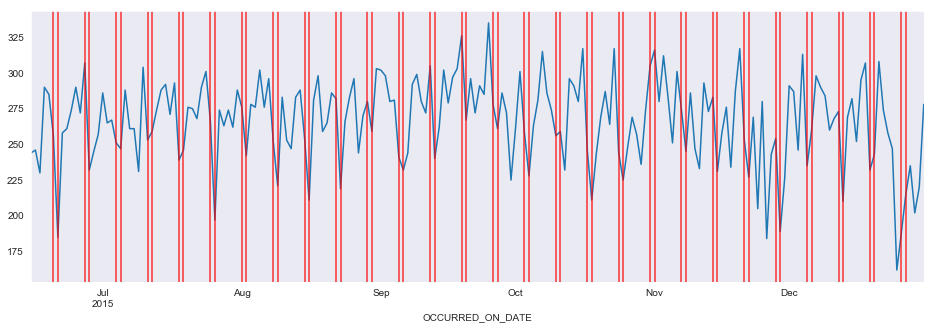

In [243]:
ax=df_day['Count'].iloc[0:200].plot(figsize=(16,5))

for day in df_day.query('Weekend==1').index:
    ax.axvline(x=day,color='red',alpha=0.8)

In [249]:
train=df_day.iloc[:942]
test=df_day.iloc[942:]

7 should be the number judged by the cycle plotted

Set Seasonal parameter as True, use 7 for daily data

In [264]:
#set the period for seasonal differencing is 7 for daily data
arstep_s=auto_arima(df_day['Count'],
                   seasonal=True,
                   m=7,
                   exogenous=df_day[['Weekend']],
                   trace=True)
                                    
arstep_s.summary()

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=11426.594, BIC=11441.807, Fit time=0.211 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=11791.436, BIC=11816.789, Fit time=1.221 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=11256.694, BIC=11282.048, Fit time=1.066 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 7); AIC=11651.982, BIC=11682.407, Fit time=1.401 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 7); AIC=11285.197, BIC=11305.480, Fit time=0.480 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 7); AIC=11481.867, BIC=11512.291, Fit time=1.675 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 2, 7); AIC=11634.133, BIC=11669.628, Fit time=2.218 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=11242.615, BIC=11273.039, Fit time=1.310 seconds
Fit ARIMA: order=(1, 0, 0) season

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1177
Model:             SARIMAX(1, 0, 1)x(0, 0, 2, 7)   Log Likelihood               -5600.335
Date:                           Sat, 07 Sep 2019   AIC                          11214.671
Time:                                   17:33:17   BIC                          11250.166
Sample:                                        0   HQIC                         11228.054
                                          - 1177                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    220.9568     28.696      7.700      0.000     164.714     277.200
x1           -25.2437      2.587     -9.756      0.000     -30.315     -20.172
ar.L1          0.2017      0.104      1.944      0.052      -0.002       0.405
ma.L1          0.0946      0.103      0.922      0.357      -0.106       0.296
ma.S.L7        0.1486      0.027      5.416      0.000       0.095       0.202
ma.S.L14       0.1455      0.030      4.797      0.000       0.086       0.205
sigma2       794.7059     26.919     29.522      0.000     741.946     847.466
===================================================================================
Ljung-Box (Q):                      269.21   Jarque-Bera (JB):                86.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.22
Prob(H) (two-sided):                  0.22   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [268]:
sax_model=SARIMAX(train['Count'],
                  order=(1,0,1),
                  seasonal_order=(0,0,2,7),
                  exog=train[['Weekend']],
                  #enforce_stationarity=False,
                  enforce_invertibility=False)

In [267]:
results=sax_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Count   No. Observations:                  942
Model:             SARIMAX(1, 0, 1)x(0, 0, 2, 7)   Log Likelihood               -4520.331
Date:                           Sat, 07 Sep 2019   AIC                           9052.662
Time:                                   17:36:21   BIC                           9081.751
Sample:                               06-15-2015   HQIC                          9063.750
                                    - 01-11-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weekend      -23.7497      2.345    -10.127      0.000     -28.346     -19.153
ar.L1          0.9942      0.001    746.231      0.000       0.992       0.997
ma.L1         -1.4231      0.056    -25.491      0.000      -1.532      -1.314
ma.S.L7        0.0709      0.029      2.453      0.014       0.014       0.128
ma.S.L14       0.1373      0.033      4.130      0.000       0.072       0.203
sigma2       427.5800     38.371     11.143      0.000     352.374     502.786
===================================================================================
Ljung-Box (Q):                       92.53   Jarque-Bera (JB):                35.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.09
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [259]:
start=len(train)
end=len(train)+len(test)-1

In [269]:
preds=results.predict(start,end,exog=test[['Weekend']]).rename('SARIMAX')

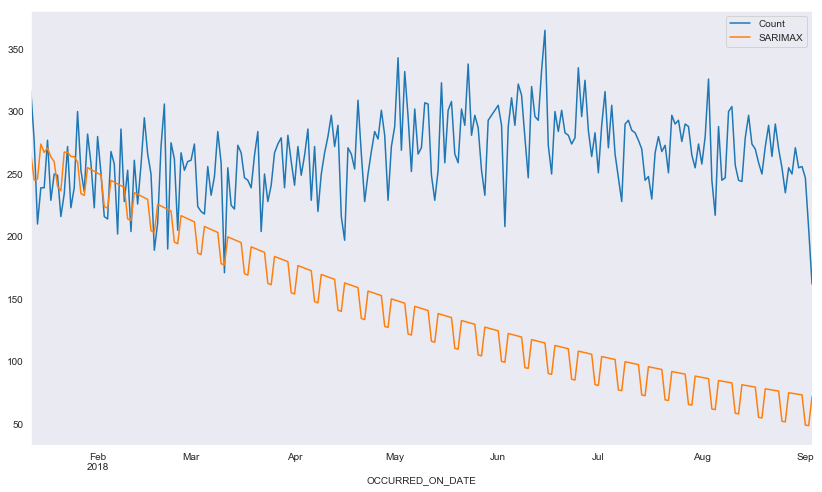

In [276]:
ax=test['Count'].plot(legend=True,figsize=(14,8))
preds.plot(legend=True)

**Evaluate the model**

In [277]:
error=mean_squared_error(test['Count'],preds)
print(f'SARIMAX(1,0,1) MSE Error: {error}')

SARIMAX(1,0,1) MSE Error: 19744.550212010457


In [278]:
error=rmse(test['Count'],preds)
print(f'SARIMAX(1,0,1) MSE Error: {error}')

SARIMAX(1,0,1) MSE Error: 140.5153024122656


**Clearly SARTIMAX should not be applied here**

## Deep Learning

In [6]:
df_t.head()

Count
Time             
2015-06-15    244
2015-06-16    246
2015-06-17    230
2015-06-18    290
2015-06-19    285

In [6]:
df_t.index

DatetimeIndex(['2015-06-15', '2015-06-16', '2015-06-17', '2015-06-18',
               '2015-06-19', '2015-06-20', '2015-06-21', '2015-06-22',
               '2015-06-23', '2015-06-24',
               ...
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03'],
              dtype='datetime64[ns]', name='Time', length=1177, freq=None)

In [7]:
len(df_t)

1177

In [8]:
len(df_t)- 365

812

In [10]:
train=df_t.iloc[:812]
test=df_t.iloc[812:]

**Normalize the data**

In [11]:
scaler=MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
train_norm = scaler.transform(train)
test_norm = scaler.transform(test)

In [126]:
'''
def normalize(df):
    result = df
    for col in df.columns:
        max_value = df[col].max()
        min_value = df[col].min()
        result[col] = (df[col] - min_value) / (max_value - min_value)
    return result.values
'''

'\ndef normalize(df):\n    result = df\n    for col in df.columns:\n        max_value = df[col].max()\n        min_value = df[col].min()\n        result[col] = (df[col] - min_value) / (max_value - min_value)\n    return result.values\n'

In [13]:
len(test)

365

In [14]:
train_norm[0:5]

array([[0.44255319],
       [0.45106383],
       [0.38297872],
       [0.63829787],
       [0.61702128]])

In [15]:
test_norm[0:5]

array([[0.32340426],
       [0.63829787],
       [0.48085106],
       [0.74893617],
       [0.8893617 ]])

In [16]:
n_input= 365
n_features =1

train_generator=TimeseriesGenerator(data=train_norm,
                              targets=train_norm,
                              length=n_input,
                              batch_size=100)

In [17]:
model_m=Sequential()

W0930 17:41:48.156840 10312 deprecation_wrapper.py:119] From C:\Users\josef\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [18]:
model_m.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

model_m.add(Dense(1))

model_m.compile(optimizer='adam',loss='mse')

W0930 17:41:53.853385 10312 deprecation_wrapper.py:119] From C:\Users\josef\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0930 17:41:53.865353 10312 deprecation_wrapper.py:119] From C:\Users\josef\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0930 17:41:54.109699 10312 deprecation_wrapper.py:119] From C:\Users\josef\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [19]:
model_m.fit_generator(train_generator,epochs=50)

W0930 17:41:57.056121 10312 deprecation.py:323] From C:\Users\josef\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0930 17:41:57.546809 10312 deprecation_wrapper.py:119] From C:\Users\josef\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0930 17:41:57.615594 10312 deprecation_wrapper.py:119] From C:\Users\josef\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 0.3196
Epoch 2/50
5/5 [==============================] - 2s 428ms/step - loss: 0.2012
Epoch 3/50
5/5 [==============================] - 2s 430ms/step - loss: 0.0856
Epoch 4/50
5/5 [==============================] - 2s 420ms/step - loss: 0.0460
Epoch 5/50
5/5 [==============================] - 2s 424ms/step - loss: 0.0326
Epoch 6/50
5/5 [==============================] - 2s 412ms/step - loss: 0.0419
Epoch 7/50
5/5 [==============================] - 2s 427ms/step - loss: 0.0349
Epoch 8/50
5/5 [==============================] - 2s 408ms/step - loss: 0.0210
Epoch 9/50
5/5 [==============================] - 2s 419ms/step - loss: 0.0192
Epoch 10/50
5/5 [==============================] - 2s 425ms/step - loss: 0.0180
Epoch 11/50
5/5 [==============================] - 2s 430ms/step - loss: 0.0171
Epoch 12/50
5/5 [==============================] - 2s 429ms/step - loss: 0.0173
Epoch 13/50
5/5 [==============================] - 2

In [20]:
model_m.history.history.keys()

dict_keys(['loss'])

In [21]:
loss_val=model_m.history.history['loss']

**Plot out the value of loss function**

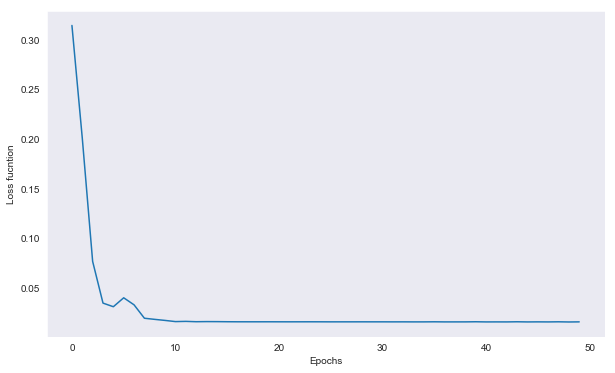

In [22]:
plt.figure(figsize=(10,6))
plt.plot(range(len(loss_val)),
               loss_val)
plt.xlabel("Epochs")
plt.ylabel("Loss fucntion");

In [23]:
# 365
first_batch=train_norm[-365:]
first_batch[0:5]

array([[0.45106383],
       [0.49787234],
       [0.39148936],
       [0.4893617 ],
       [0.45531915]])

In [24]:
first_batch=first_batch.reshape(1, n_input, n_features)

In [25]:
first_batch.shape

(1, 365, 1)

In [26]:
model_m.predict(first_batch)

array([[0.6169482]], dtype=float32)

In [27]:
test_pred=[]

#last input points from the trainign set 
first_batch=train_norm[-n_input:]

#reshape to the RNN format
current_batch=first_batch.reshape(1,n_input,n_features)


# predict to the length of test size
for i in range(len(test)):
    
    #One timestamp ahead of historical 365 points
    current_pred=model_m.predict(current_batch)[0]
    
    test_pred.append(current_pred)
    
    #Update current batch to include prediction
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
    

In [28]:
true_pred=scaler.inverse_transform(test_pred)
true_pred[:10]

array([[284.98282403],
       [285.64245999],
       [285.63373357],
       [285.53457737],
       [285.3908506 ],
       [285.22742987],
       [285.05764991],
       [284.88833219],
       [284.7226423 ],
       [284.56178486]])

**Append Predicstion reults as a new column to the original dataframe**

In [29]:
test['RNN_Pred']=true_pred

In [30]:
test.head(8)

Count    RNN_Pred
Time                         
2017-09-04    216  284.982824
2017-09-05    290  285.642460
2017-09-06    253  285.633734
2017-09-07    316  285.534577
2017-09-08    349  285.390851
2017-09-09    271  285.227430
2017-09-10    244  285.057650
2017-09-11    306  284.888332

**Evaluate the model**

In [31]:
(test['RNN_Pred'].mean()-test['Count'].mean())/test['Count'].mean()

0.041122737371784644

In [32]:
error=mean_squared_error(test['Count'],true_pred)
print(f'RNN MSE Error: {error}')

RNN MSE Error: 1296.0310834054112


In [33]:
error=rmse(test['Count'],true_pred).mean()
print(f'RNN RMSE Error: {error}')

RNN RMSE Error: 28.25028063176976


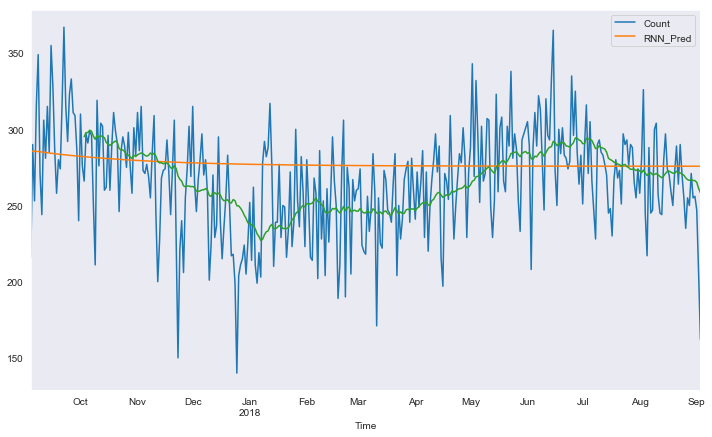

In [34]:
test.plot(figsize=(12,7))
test['Count'].rolling(window=30).mean().plot()
#df_t['Count'][812:].rolling(window=300).mean().rename('Actual Mean').plot(legend=True)